In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC,LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.externals import joblib

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

from scipy.stats import skew, kurtosis

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


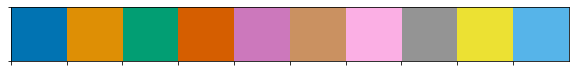

In [2]:
from code.models import cv_check, cv_bp, model_score, mod_eval, model_training
from code.preprocessing import preprocess, prop_check, make_index, categorize, add_feat

### import data

In [3]:
data_set = pd.read_csv('loan_data_set_bias.csv')

In [4]:
preprocess(data_set)
#prop_check(data_set)
data_set = make_index(data_set)
data_set = categorize(data_set)
data_set.Loan_Status.replace({'Y': 1, 'N':0}, inplace=True)

## Model selection

> ### Adding new features:
- naive estimation of monthly loan return (LoanAmount/Loan_Amount_Term) normalized and with ln() let us get the distribution as closer as can be to normal distribution
- total income (ApplicantIncome + CoaplicantIncome) normlized and with ln() let us get the distribution as closer as can be to normal distribution

In [5]:
data_set = add_feat(data_set)

- lets check the new features distributions

In [6]:
#norm_plt(data_set)

- the skew and the kurtosis are much closer to 0, as expected from normalized normal distribution
- now lets drop the neglectable features those are dependeds of the new features created above
- i found in previous runs the Married and Dependents are neglectable too

In [7]:
dropit=['LoanAmount', 
        'Loan_Amount_Term', 
        'ApplicantIncome',
        'CoapplicantIncome',
        'Married',
        'Dependents_0',
        'Dependents_1',
        'Dependents_2']
data_set.drop(columns=dropit, 
           inplace=True)

- the following is a sanity check for the distribution between Y and N in the target column
- the distribution between the values didn't change much (less than 0.5%)

In [8]:
data_set['Loan_Status'].value_counts(normalize=True)
#sns.barplot(data = data_set.Loan_Status.value_counts(normalize = True).reset_index(),
#            x = 'index',
#            y = 'Loan_Status',
#            palette=current_palette)
#plt.grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

1    0.8375
0    0.1625
Name: Loan_Status, dtype: float64

### Classifiers optimization

- In our case: binary classification, the "cross_val_score" function uses StratifiedKFold cross validation to reduce the bias effect in imbalanced data.
- it is a good approach for the cases the target column distribution is biased

Currently fitting: RandomForestClassifier
Currently fitting: SVC
Currently fitting: LogisticRegression
Currently fitting: GaussianNB
Currently fitting: DummyClassifier


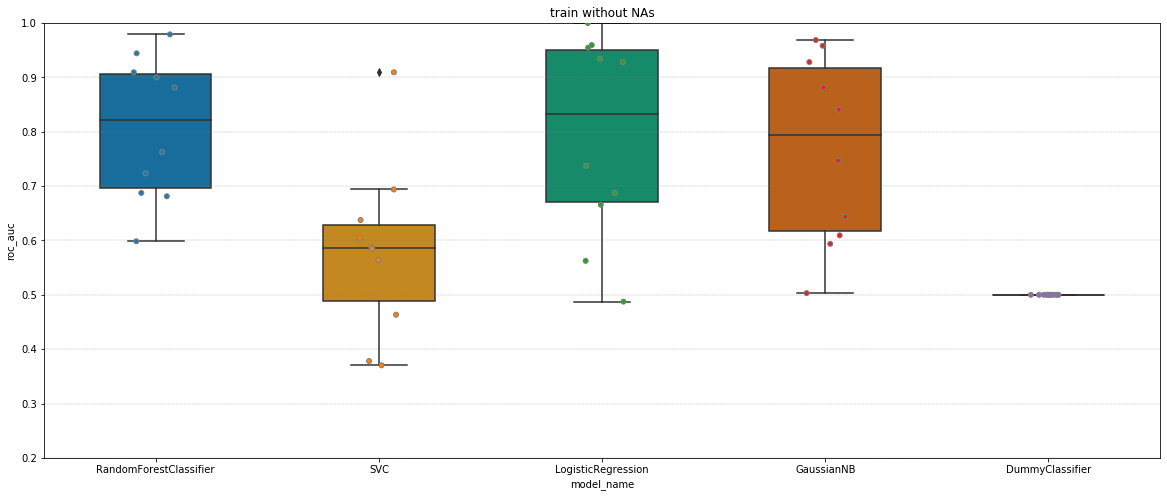

In [9]:
f, axes = plt.subplots(1,1,figsize= (20,8),squeeze=False, sharey=True)
cv_bp(cv_check(data_set.drop(['Loan_Status'],axis=1),
               data_set.Loan_Status,10), '{} without NAs'.format('train'),axes[0,0])

- using grid search cross validation we scanned to find the optimal values for each model variables
- the values chosen after several runs to get the optimum variables within the optimal range for the roc_auc as closer we can get to 1

### RandomForest

In [10]:
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']

rf_cv = model_score(data_set,
            RandomForestClassifier(random_state=42, 
                                   n_jobs=4, 
                                   class_weight='balanced_subsample', 
                                   n_estimators=50), 
            grid_values, 
            scorers_list)

temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==4]
temp_df1['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==4]
temp_df1.set_index('max_depth', inplace=True)
print('4:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==6]
temp_df2['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==6]
temp_df2.set_index('max_depth', inplace=True)
print('6:\n')
temp_df2

/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for accuracy: {'max_depth': 11, 'max_features': 5} scoring: 0.833


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for roc_auc: {'max_depth': 7, 'max_features': 5} scoring: 0.799


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for precision: {'max_depth': 3, 'max_features': 6} scoring: 0.931


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for recall: {'max_depth': 13, 'max_features': 4} scoring: 0.935
Grid best parameters for f1: {'max_depth': 11, 'max_features': 5} scoring: 0.903
4:



/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


,accuracy,roc_auc,precision,recall,f1
max_depth,,,,,
3,0.785417,0.783211,0.913742,0.823117,0.864936
7,0.810417,0.786630,0.876743,0.900340,0.887971
11,0.818750,0.776929,0.863281,0.930123,0.895266
13,0.829167,0.770345,0.870224,0.935154,0.901266


6:



,accuracy,roc_auc,precision,recall,f1
max_depth,,,,,
3,0.795833,0.783430,0.930923,0.818179,0.869950
7,0.816667,0.792933,0.883277,0.900309,0.891067
11,0.831250,0.774548,0.877357,0.927685,0.901677
13,0.827083,0.773394,0.874957,0.925185,0.899151


### LogisticRegression

In [16]:
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


lr_cv = model_score(data_set,
                    LogisticRegression(solver='liblinear',random_state=42, max_iter=500,
                                      class_weight='balanced'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l1']
temp_df1['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l1']
temp_df1.set_index('C', inplace=True)
print('l1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l2']
temp_df2['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l2']
temp_df2.set_index('C', inplace=True)
print('l2:\n')
temp_df2

/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for accuracy: {'C': 0.1, 'penalty': 'l2'} scoring: 0.792


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for roc_auc: {'C': 100, 'penalty': 'l1'} scoring: 0.782


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for precision: {'C': 1, 'penalty': 'l1'} scoring: 0.948


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for recall: {'C': 0.1, 'penalty': 'l1'} scoring: 0.836
Grid best parameters for f1: {'C': 0.1, 'penalty': 'l2'} scoring: 0.87
l1:



/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


,accuracy,roc_auc,precision,recall,f1
C,,,,,
0.01,0.481250,0.534911,0.858349,0.457716,0.595972
0.10,0.779167,0.775966,0.897012,0.835833,0.864124
1.00,0.787500,0.780823,0.948150,0.790833,0.861197
10.00,0.787500,0.780792,0.945646,0.793302,0.861475
100.00,0.787500,0.781919,0.945646,0.793302,0.861475


l2:



,accuracy,roc_auc,precision,recall,f1
C,,,,,
0.01,0.747917,0.669984,0.871580,0.821142,0.844425
0.10,0.791667,0.771989,0.918364,0.828272,0.869877
1.00,0.789583,0.772246,0.944009,0.798333,0.863729
10.00,0.791667,0.779394,0.946063,0.798302,0.864674
100.00,0.787500,0.781919,0.945646,0.793302,0.861475


### SVC

In [17]:
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


svc_cv = model_score(data_set,
                    SVC(random_state=42, class_weight='balanced',kernel='rbf'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==1]
temp_df1['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==1]
temp_df1.set_index('gamma', inplace=True)
print('C=1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==10]
temp_df2['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==10]
temp_df2.set_index('gamma', inplace=True)
print('C=10:\n')
temp_df2

/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for accuracy: {'C': 1, 'gamma': 0.9} scoring: 0.84


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for roc_auc: {'C': 10, 'gamma': 0.95} scoring: 0.527


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for precision: {'C': 1, 'gamma': 0.9} scoring: 0.841


/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Grid best parameters for recall: {'C': 1, 'gamma': 0.9} scoring: 0.998
Grid best parameters for f1: {'C': 1, 'gamma': 0.9} scoring: 0.912
C=1:



/Users/Jona/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


,accuracy,roc_auc,precision,recall,f1
gamma,,,,,
0.50,0.833333,0.520069,0.839679,0.990062,0.908661
0.70,0.835417,0.517125,0.840037,0.992562,0.909922
0.90,0.839583,0.523592,0.840702,0.997531,0.912403
0.95,0.835417,0.526349,0.837171,0.997531,0.910324


C=10:



,accuracy,roc_auc,precision,recall,f1
gamma,,,,,
0.50,0.831250,0.525721,0.839343,0.987562,0.907413
0.70,0.835417,0.520738,0.840037,0.992562,0.909922
0.90,0.839583,0.525222,0.840702,0.997531,0.912403
0.95,0.835417,0.526670,0.837171,0.997531,0.910324


### Chosen values per model

In [18]:
#RandomForest
max_depth=11
max_features=6

In [19]:
#LogisticRegression
lr_C=0.1
penalty='l1'

In [20]:
#SVC
svc_C=1
gamma=0.9

In [21]:
#Test Size


## RandomForest

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.99      0.99      0.99       134

    accuracy                           0.97       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.97      0.97      0.97       160



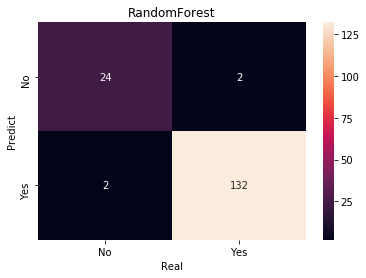

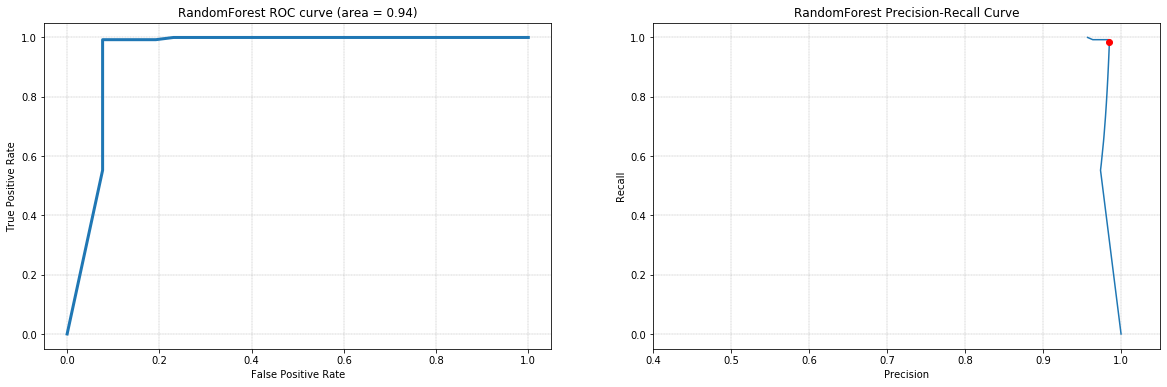

In [22]:
ts = 0.333
rf = model_training(RandomForestClassifier(random_state=42, 
                                           n_jobs=4, 
                                           n_estimators=50, 
                                           max_depth=max_depth,
                                           max_features=max_features),data_set, ts)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                     data_set['Loan_Status'],
                                                     test_size=.333,
                                                     stratify=data_set['Loan_Status'])

mod_eval(data_set, rf.predict(X_test), rf.predict_proba(X_test), y_test, 'RandomForest')
fi_df = pd.DataFrame({'fi': rf.feature_importances_},index=t.columns).sort_values(by='fi', ascending=False)
X_train.to_csv('x_train.csv')

In [23]:
X_train.head()

,Gender,Education,Self_Employed,Credit_History,Property_Area_Semiurban,Property_Area_Urban,ln_monthly_return,ln_total_income,ln_LoanAmount
Loan_ID,,,,,,,,,
LP002603,0,1,0,1.0,0,0,-19.135808,-12.140233,-5.197850
LP001924,1,1,0,1.0,0,0,-17.230978,2.613966,-15.458367
LP002187,1,1,0,1.0,1,0,-25.482808,-34.557055,-12.204596
LP001577,0,1,0,1.0,0,0,-8.282617,-9.801878,-5.579859
LP001068,1,1,0,1.0,1,0,-4.953307,-5.822247,-1.904482


## LogisticRegression

              precision    recall  f1-score   support

           0       0.45      0.58      0.51        26
           1       0.91      0.87      0.89       134

    accuracy                           0.82       160
   macro avg       0.68      0.72      0.70       160
weighted avg       0.84      0.82      0.83       160



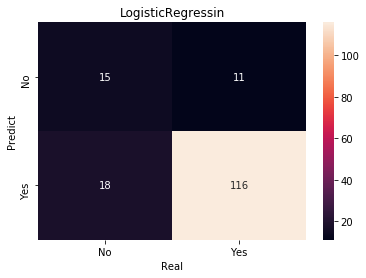

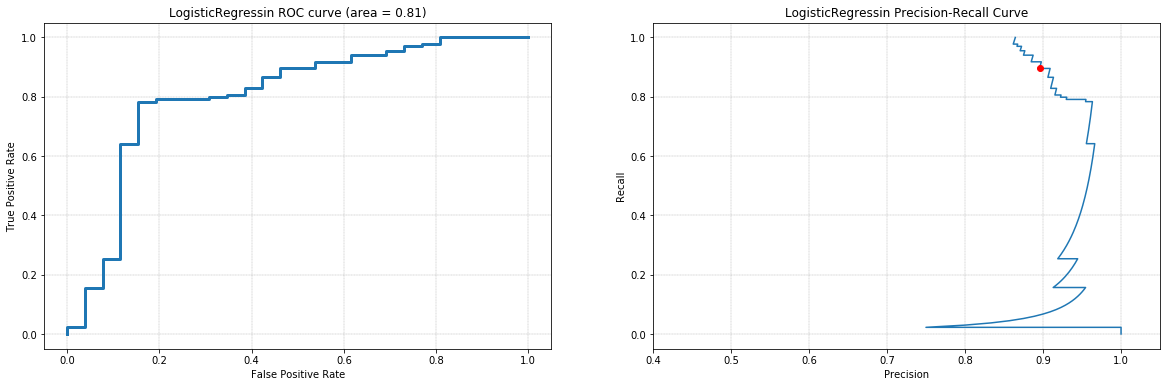

In [27]:
ts=0.333
lr = model_training(LogisticRegression(C=lr_C, 
                                       penalty=penalty,
                                       solver='liblinear',
                                       max_iter=1000),data_set, ts)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])

t = 0.71
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]

#pred_y = lr.predict(X_test)
mod_eval(data_set, pred_y, lr.predict_proba(X_test), y_test, 'LogisticRegressin') 
plt.show()

## NaiveBayes

              precision    recall  f1-score   support

           0       0.41      0.81      0.55        26
           1       0.95      0.78      0.86       134

    accuracy                           0.78       160
   macro avg       0.68      0.79      0.70       160
weighted avg       0.87      0.78      0.81       160



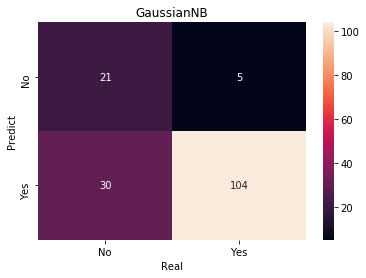

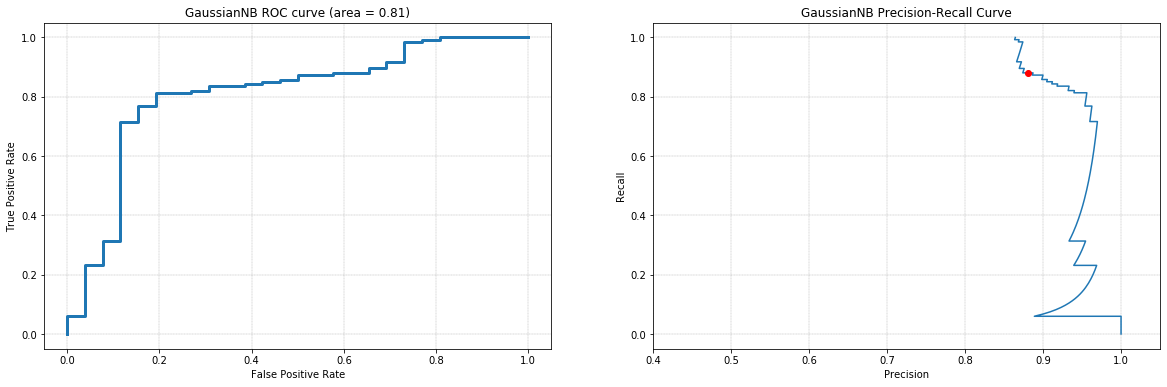

In [28]:
gnb = model_training(GaussianNB(),data_set, ts)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])


t = 0.75
predprob = gnb.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = gnb.predict(X_test)
mod_eval(data_set,pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')
plt.show()

## SVC

In [30]:
svc = model_training(SVC(kernel='linear',
                         C=1, 
                         gamma='auto',
                         class_weight='balanced',
                         probability=True),data_set, ts)
t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])

t=0.75
predprob = svc.predict_proba(X_test)
pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]

In [31]:
#export preTrained models

from joblib import dump, load


dump(svc, 'svc_loan_bias.joblib')
dump(rf, 'rf_loan_bias.joblib')
dump(gnb, 'gnb_loan_bias.joblib')
dump(lr, 'lr_loan_bias.joblib')

['svc_loan_bias.joblib']

['rf_loan_bias.joblib']

['gnb_loan_bias.joblib']

['lr_loan_bias.joblib']

In [ ]:
import aif360

In [11]:
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display

In [ ]:
#quick demonstration of disparate impact using a built in dataset

dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

#dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [12]:
#back to the initial loan application dataset

data_set.head()

,Gender,Education,Self_Employed,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban,ln_monthly_return,ln_total_income,ln_LoanAmount
Loan_ID,,,,,,,,,,
LP001003,1,1,0,1.0,1,0,0,-3.084347,1.817078,0.158749
LP001005,1,1,1,1.0,1,0,1,-28.870091,-27.109971,-28.307318
LP001006,1,0,0,1.0,1,0,1,-5.596780,-6.729698,-2.614841
LP001008,1,1,0,1.0,1,0,1,0.681259,1.202233,4.315774
LP001011,1,1,1,1.0,1,0,1,25.537110,20.455218,31.755291


In [13]:
#code from: https://www.ambiata.com/blog/2019-12-13-bias-detection-and-mitigation/

def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)

df_aif = BinaryLabelDataset(df=data_set, label_names=['Loan_Status'], protected_attribute_names=['Gender'])

privileged_group = [{'Gender': 1}] #male=1
unprivileged_group = [{'Gender': 0}] #female=0

In [14]:
metric_orig = BinaryLabelDatasetMetric(df_aif, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.466


This is the probability of success given the jobseeker is unprivileged (female), divided by the probability of success given the jobseeker is privileged (male). We further recast this as 1 - min(DI, 1/DI), since DI can be greater than 1, which would mean that the privileged group is disadvantaged. For our fairness benchmark, we require that 1 - min(DI, 1/DI) < 0.2

In [15]:
if get_disparity_index(metric_orig.disparate_impact()).round(3) < 0.2:
    print('The original data can be considered to be not biased')
else:
    print('There is a potential bias')

There is a potential bias


Now let's check the predicted results of the previously defined test data to see if the model output was biased when feeding it test data

In [ ]:
df = pd.DataFrame(pred_y, columns=['Pred'])
pred_test = pd.concat([X_test.reset_index(drop='True'),df.reset_index(drop='True')],axis=1)

In [ ]:
df_aif = BinaryLabelDataset(df=pred_test, label_names=['Pred'], protected_attribute_names=['Gender'])

metric_orig = BinaryLabelDatasetMetric(df_aif, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig.disparate_impact()).round(3))

In [ ]:
if get_disparity_index(metric_orig.disparate_impact()).round(3) < 0.2:
    print('The outcome of the test data can be considered to be not biased')
else:
    print('There is a potential bias')

As a next step, random data is generated to see if the pre-trained model shows a bias on completely unbiased data

In [ ]:
X_test.dtypes

In [ ]:
X_test.describe()

In [ ]:
X_test.columns

In [ ]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

X_new = pd.DataFrame(columns=[])

for c in X_test.columns:
    if is_binary(X_test[c]):
        X_new[c] = np.random.binomial(1, .5, 1000)
    else:
        X_new[c] = np.random.normal(X_test[c].describe()[1], X_test[c].describe()[2], 1000)

In [ ]:
X_new.head()

Predicting the loan application outcome with the normally distributed data

In [ ]:
pred_y_n = svc.predict(X_new)

In [ ]:
df_n = pd.DataFrame(pred_y_n, columns=['Pred'])
pred_n = pd.concat([X_new.reset_index(drop='True'),df_n.reset_index(drop='True')],axis=1)

In [ ]:
df_aif = BinaryLabelDataset(df=pred_n, label_names=['Pred'], protected_attribute_names=['Gender'])

metric_orig = BinaryLabelDatasetMetric(df_aif, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig.disparate_impact()).round(3))

In [ ]:
if get_disparity_index(metric_orig.disparate_impact()).round(3) < 0.2:
    print('The outcome of the test data can be considered to be not biased')
else:
    print('There is a potential bias')